In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from decipher.datasets.decipher_data import Decipher
from decipher.datasets.gdsc import GDSC
from decipher.datasets.depmap import DepMap
from scipy.stats import mannwhitneyu
from decipher import PROJECT_BASE
import pandas as pd

from scipy.optimize import curve_fit

# plt.rcParams["font.family"] = "FreeSans"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
decipher = Decipher()

In [4]:
genepair_residuals = pd.read_csv(
    PROJECT_BASE
    / "data/decipher/giscores-v9/Residuals/decipher_genepair_residuals.csv",
    index_col=[0, 1],
)

Text(1, 3.5, '*')

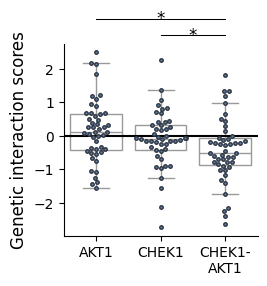

In [5]:
indices = {
    "AKT1": ("AKT1", "AAVS"),
    "CHEK1": ("AAVS", "CHEK1"),
    "CHEK1-\nAKT1": ("AKT1", "CHEK1"),
}

df = pd.concat(
    [
        pd.DataFrame(genepair_residuals.loc[index].values.ravel()).assign(name=name)
        for name, index in indices.items()
    ],
    axis=0,
)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
sns.boxplot(
    data=df,
    x="name",
    y=0,
    ax=ax,
    fliersize=0,
    color="white",
)
sns.swarmplot(
    data=df, x="name", y=0, size=2.5, color="#5e81ac", edgecolor="#2e3440", linewidth=1
)

ax.axhline(0, color="black")
ax.spines[["top", "right"]].set_visible(False)

ax.set_ylabel("Genetic interaction scores", fontsize=12)
ax.set_xlabel(None)

line1 = Line2D([0, 2], [3.5, 3.5], color="black", linewidth=0.75)
line1.set_clip_on(False)
line2 = Line2D([1, 2], [3, 3], color="black", linewidth=0.75)
line2.set_clip_on(False)

ax.add_line(line1)
ax.add_line(line2)

ax.text(1.5, 3, "*", ha="center", va="center", fontsize=12)
ax.text(1, 3.5, "*", ha="center", va="center", fontsize=12)

# fig.savefig("figures/chek1-akt1-giscores.pdf", transparent=True)

In [6]:
gdsc = GDSC().load_all()

/tmp/ipykernel_15943/1483438224.py:27: RuntimeWarning: invalid value encountered in log2
  wt_values = np.log2(wt_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:28: RuntimeWarning: invalid value encountered in log2
  mutated_values = np.log2(mutated_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:27: RuntimeWarning: invalid value encountered in log2
  wt_values = np.log2(wt_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:28: RuntimeWarning: invalid value encountered in log2
  mutated_values = np.log2(mutated_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:27: RuntimeWarning: invalid value encountered in log2
  wt_values = np.log2(wt_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:28: RuntimeWarning: invalid value encountered in log2
  mutated_values = np.log2(mutated_values / wt_median)
/tmp/ipykernel_15943/1483438224.py:27: RuntimeWarning: invalid value encountered in log2
  wt_values = np.log2(wt_values / wt_median)
/tmp/ipykernel_15943/1483438224.

(-0.75, 5.7)

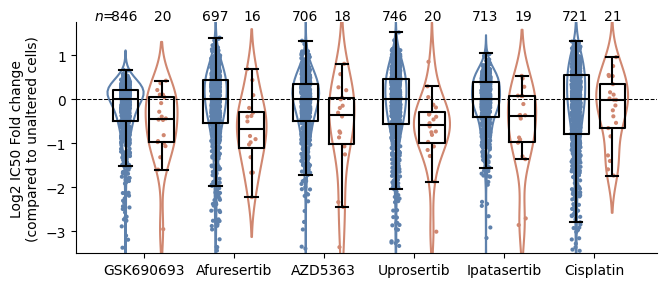

In [7]:
akt1_drugs_1 = ["GSK690693"]
akt1_drugs_2 = ["Afuresertib", "AZD5363", "Uprosertib", "Ipatasertib", "Cisplatin"]

mutated, wt = gdsc.separate_cell_lines("CHEK1", mutation_data_name="sq_mutations")

data = ["GDSC1"] * len(akt1_drugs_1) + ["GDSC2"] * len(akt1_drugs_2)
akt1_drugs = akt1_drugs_1 + akt1_drugs_2

classes = []
values = []
drugs = []

for _data, drug in zip(data, akt1_drugs):
    df = gdsc.drug_data[_data]
    _mutated = np.intersect1d(mutated, df.columns)
    _wt = np.intersect1d(wt, df.columns)

    mutated_values = df.loc[drug, _mutated].values
    wt_values = df.loc[drug, _wt].values

    mutated_values = mutated_values[np.isfinite(mutated_values)]
    wt_values = wt_values[np.isfinite(wt_values)]

    wt_median = np.nanmedian(wt_values)
    mutated_median = np.nanmedian(mutated_values)

    wt_values = np.log2(wt_values / wt_median)
    mutated_values = np.log2(mutated_values / wt_median)

    eps = np.nanmedian(wt_values)
    wt_values -= eps
    mutated_values -= eps

    classes.append(["wildtype"] * len(wt_values))
    classes.append(["mutated"] * len(mutated_values))
    values.append(wt_values)
    values.append(mutated_values)
    drugs.append([drug] * (len(wt_values) + len(mutated_values)))

classes = np.hstack(classes)
values = np.hstack(values)
drugs = np.hstack(drugs)

data = pd.DataFrame.from_dict({"drugs": drugs, "status": classes, "values": values})

palette = {"wildtype": "#5E81AC", "mutated": "#D08770"}

fig, ax = plt.subplots(figsize=(7.5, 3))
sns.stripplot(
    data=data, x="drugs", y="values", hue="status", palette=palette, dodge=True, size=3
)
sns.violinplot(
    data=data,
    x="drugs",
    y="values",
    hue="status",
    palette=palette,
    fill=False,
    inner=None,
)
sns.boxplot(
    data=data,
    x="drugs",
    y="values",
    hue="status",
    palette={"mutated": "black", "wildtype": "black"},
    fliersize=0,
    fill=False,
    width=0.8,
    gap=0.3,
    zorder=10,
)
sns.despine()
ax.set_ylim([-3.5, 1.75])
# ax.set_yticks(np.arange(-2, 4))
# ax.set_yticklabels([0.01, 0.1, 1, 10, 100, 1000])
# ax.set_ylabel("IC50")
ax.get_legend().set_visible(False)
ax.axhline(0, color="black", linewidth=0.75, linestyle="--")

ax.set_ylabel("Log2 IC50 Fold change\n(compared to unaltered cells)")
ax.set_xlabel(None)

counts = data.groupby(["drugs", "status"]).count()
order = [
    "GSK690693",
    "Afuresertib",
    "AZD5363",
    "Uprosertib",
    "Ipatasertib",
    "Cisplatin",
]
for ind, drug in enumerate(order):
    ax.text(ind - 0.21, 1.8, counts.loc[drug, "wildtype"].values[0], ha="center")
    ax.text(ind + 0.21, 1.8, counts.loc[drug, "mutated"].values[0], ha="center")

ax.text(-0.55, 1.8, "$n$=")
ax.set_xlim([-0.75, 5.7])

In [8]:
for drug, df in data.groupby('drugs'): 
    wt = df.loc[df['status'] == 'wildtype', 'values']
    mut = df.loc[df['status'] == 'mutated', 'values']
    print(drug, mannwhitneyu(wt, mut, nan_policy='omit'))

AZD5363 MannwhitneyuResult(statistic=8258.0, pvalue=0.02982697384014186)
Afuresertib MannwhitneyuResult(statistic=7826.0, pvalue=0.005752969755852291)
Cisplatin MannwhitneyuResult(statistic=8095.0, pvalue=0.588376234166764)
GSK690693 MannwhitneyuResult(statistic=11027.0, pvalue=0.020273283913311322)
Ipatasertib MannwhitneyuResult(statistic=9253.0, pvalue=0.0064268389387761886)
Uprosertib MannwhitneyuResult(statistic=10500.0, pvalue=0.0018550408151461297)


GSK690693
Afuresertib
AZD5363
Uprosertib
Ipatasertib
Cisplatin


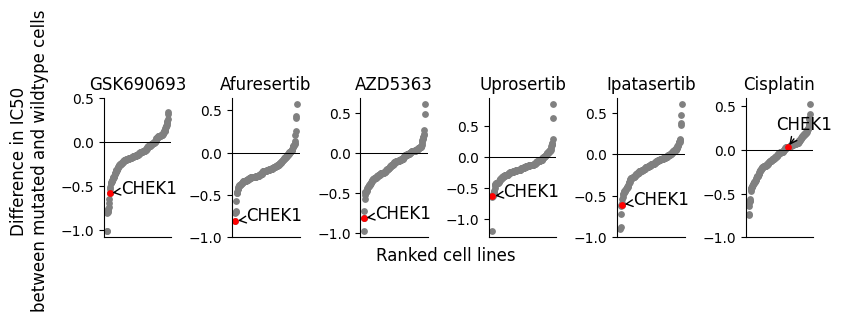

In [9]:
def get_responses(drug_df, drug):
    df = drug_df[drug_df["Drug name"] == drug]
    df = df.set_index("Cell line name")["IC50"]
    return df

mutated, wt = gdsc.separate_cell_lines("CHEK1", mutation_data_name="sq_mutations")
columns = np.intersect1d(gdsc.sq_mutations.columns, decipher.genes)

akt1_drugs_1 = ["GSK690693"]
akt1_drugs_2 = ["Afuresertib", "AZD5363", "Uprosertib", "Ipatasertib", "Cisplatin"]

drug_data_map = {
    "gdsc1": (gdsc.drug1, akt1_drugs_1),
    "gdsc2": (gdsc.drug2, akt1_drugs_2),
}

features = gdsc.sq_mutations[columns].astype(int)
# features = (features - features.mean(axis=0)) / features.std(axis=0)

X_map = {}
y_map = {}

models_map = {}
for drug_df, drugs in drug_data_map.values():
    for drug in drugs:
        print(drug)

        y = get_responses(drug_df, drug)
        cell_lines = y.index.intersection(features.index)

        X = features.loc[cell_lines]
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        y = y.loc[cell_lines]
        y = y.reset_index().groupby("index").median()["IC50"]
        y = (y - np.mean(y)) / np.std(y)

        X_map[drug] = X
        y_map[drug] = y


fig, axes = plt.subplots(1, 6, figsize=(8, 2), tight_layout=True)
axes = np.ravel(axes)

drugs = [
    "GSK690693",
    "Afuresertib",
    "AZD5363",
    "Uprosertib",
    "Ipatasertib",
    "Cisplatin",
]

for ind, ax in enumerate(axes):
    drug = drugs[ind]

    X = X_map[drug]
    y = y_map[drug]

    diffs = []
    for gene in X.columns:
        diff = np.median(y[X[gene] > 0]) - np.median(y[X[gene] < 0])
        diffs.append(diff)

    diffs = pd.Series(diffs, index=X.columns).sort_values()

    ax.scatter(np.arange(len(diffs)), diffs.values, color="grey", s=15)
    index = np.argwhere(diffs.index == "CHEK1").ravel()[0]
    x, y = index, diffs.iloc[index]
    ax.scatter(x, y, color="red", s=15)
    if ind == 5:
        xytext = (x - 40, y + 0.2)
    else:
        xytext = (x + 40, y)
    ax.annotate("CHEK1", (x, y), xytext, fontsize=12, arrowprops=dict(arrowstyle="->"))
    ax.set_xticks([])
    ax.axhline(0, color="black", linewidth=0.75)
    ax.set_yticks([-1, -0.5, 0, 0.5])

    ax.set_title(drug)

fig.text(
    -0.02,
    0.5,
    "Difference in IC50\nbetween mutated and wildtype cells",
    rotation=90,
    va="center",
    fontsize=12,
    ha="center",
)
fig.text(0.5, 0, "Ranked cell lines", fontsize=12, ha="center")

sns.despine()